Here we demonstrate the generating of polyhedrons, whos feasible region is either empty or not. 
When given an appropriate cost vector the area contains a feasible solution. 

Additionally, we are keeping our decision variables (n) and our constraints (m) constant, since the problem of varying input dimension to our model significnatly increases the complexlixty of the project. This topic will be explored in more detail later in the further research section. This part of the project will likely be cut out and made into its own repository.

We plot the polyhedron (for n = 2) and label whether it is bounded or not. 
With the cost vector, if the feasible solution is unbounded we can simply take the dual of it and have an infeasible problem.
We will be graphing the primal problem as demonstration.

The linear program will take the standard form:
minimize: z = c'x
subject to: Ax <= b


A 
[[ 6 -9]
 [ 5 -4]
 [ 8  6]]

b 
[4 3 6]

c 
[-10  -8]

<class 'pulp.pulp.LpAffineExpression'>
Test_Generation:
MINIMIZE
-10*x1 + -8*x2 + 0
SUBJECT TO
_C1: 6 x1 - 9 x2 <= 4

_C2: 5 x1 - 4 x2 <= 3

_C3: 8 x1 + 6 x2 <= 6

VARIABLES
x1 free Continuous
x2 free Continuous

Unbounded
[-5.59528209  1.11917959]


C:\Python310\lib\site-packages\pulp\pulp.py:1352: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


(array([[-10.        ,  10.        ],
        [-10.        ,  -7.11111111],
        [  0.52380952,  -0.0952381 ],
        [  0.67741935,   0.09677419],
        [ -6.75      ,  10.        ]]),
 array([-5.59528209,  1.11917959]),
 <scipy.spatial._qhull.HalfspaceIntersection at 0x25687793c70>)

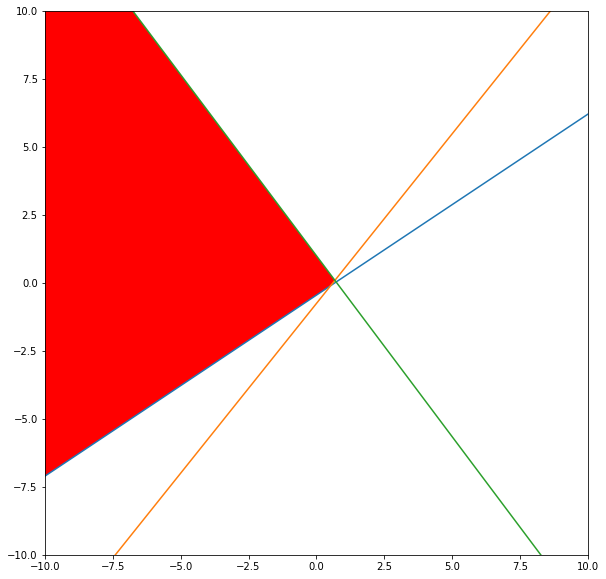

In [144]:
import matplotlib.pyplot as plt

import numpy as np
from scipy.spatial import HalfspaceIntersection, ConvexHull
from scipy.optimize import linprog

import pulp

def feasible_point(A, b):
    # finds the center of the largest sphere fitting in the convex hull
    norm_vector = np.linalg.norm(A, axis=1)
    A_ = np.hstack((A, norm_vector[:, None]))
    b_ = b[:, None]
    c = np.zeros((A.shape[1] + 1,))
    c[-1] = -1
    res = linprog(c, A_ub=A_, b_ub=b[:, None], bounds=(None, None))
    return res.x[:-1]
    
def hs_intersection(A, b):
    interior_point = feasible_point(A, b)
    halfspaces = np.hstack((A, -b[:, None]))
    hs = HalfspaceIntersection(halfspaces, interior_point)
    return hs

def plt_halfspace(a, b, bbox, ax):
    if a[1] == 0:
        ax.axvline(b / a[0])
    else:
        x = np.linspace(bbox[0][0], bbox[0][1], 100)
        ax.plot(x, (b - a[0]*x) / a[1])

def add_bbox(A, b, xrange, yrange):
    A = np.vstack((A, [
        [-1,  0],
        [ 1,  0],
        [ 0, -1],
        [ 0,  1],
    ]))
    b = np.hstack((b, [-xrange[0], xrange[1], -yrange[0], yrange[1]]))
    return A, b

def solve_convex_set(A, b, bbox, ax=None):
    A_, b_ = add_bbox(A, b, *bbox)
    interior_point = feasible_point(A_, b_)
    hs = hs_intersection(A_, b_)
    points = hs.intersections
    hull = ConvexHull(points)
    return points[hull.vertices], interior_point, hs

def plot_convex_set(A, b, bbox, ax=None):
    # solve and plot just the convex set (no lines for the inequations)
    points, interior_point, hs = solve_convex_set(A, b, bbox, ax=ax)
    if ax is None:
        _, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.set_xlim(bbox[0])
    ax.set_ylim(bbox[1])
    ax.fill(points[:, 0], points[:, 1], 'r')
    return points, interior_point, hs

def plot_inequalities(A, b, c, bbox, ax=None):
    # solve and plot the convex set,
    # the inequation lines, and
    # the interior point that was used for the halfspace intersections
    points, interior_point, hs = plot_convex_set(A, b, bbox, ax=ax)
    #ax.plot(*interior_point, 'o')
    print(interior_point)
    for a_k, b_k in zip(A, b):
        plt_halfspace(a_k, b_k, bbox, ax)
    return points, interior_point, hs

def generate_linear_program(n, m, lower_entry_bound, upper_entry_bound):

    a_matrix = np.random.randint(lower_entry_bound,upper_entry_bound,size = (m,n))
    b_vector = np.random.randint(lower_entry_bound,upper_entry_bound,size = (m))
    c_vector = np.random.randint(lower_entry_bound,upper_entry_bound,size = (n))

    # Making Ax <= b with b being positive
    for i in range(len(b_vector)):
        if b_vector[i] <= 0:
            b_vector[i] = b_vector[i] * -1
            a_matrix[i] = a_matrix[i] * -1
    
    return (a_matrix, b_vector, c_vector)

n = 2
m = 3

lower_entry_bound = -10
upper_entry_bound = 10

a_matrix, b_vector, c_vector = generate_linear_program(n,m,lower_entry_bound,upper_entry_bound)

print(f'A \n{a_matrix}\n')
print(f'b \n{b_vector}\n')
print(f'c \n{c_vector}\n')

linear_program = pulp.LpProblem("Test Generation", pulp.LpMinimize)
solver = pulp.PULP_CBC_CMD()
#? Have to figure out a way to dynamically generate variables for LP or use a differnt method to check infeasible/unbounded
x1 = pulp.LpVariable('x1', cat='Continuous')
x2 = pulp.LpVariable('x2', cat='Continuous')
#test = c_vector[0] * x1 + c_vector[1] * x2, 'Z'
print(type(test[0]))
linear_program += c_vector[0] * x1 + c_vector[1] * x2, 'Z'
for i in range(len(a_matrix)):
    linear_program += a_matrix[i][0] * x1 + a_matrix[i][1] * x2 <= b_vector[i]
print(linear_program)
result = linear_program.solve(solver)
status = pulp.LpStatus[linear_program.status]
print(status)

plt.rcParams['figure.figsize'] = (10, 10)
bbox = [(-10, 10), (-10, 10)]
fig, ax = plt.subplots()
plot_inequalities(a_matrix, b_vector, c_vector, bbox, ax)

In [485]:
import pulp as pl
import numpy as np

def generate_uniformly_random_linear_program(min=np.random.choice([0,1]), decision_variables=np.random.randint(-10,10), constraints=np.random.randint(-10,10), iteration=0):
    #? Randomly Determines Whether To Generate A Maximize or Minimize Problem
    if min == 1:
        linear_program = pl.LpProblem(f"Primal_Linear_Program_{iteration}", pl.LpMinimize)
    else:
        linear_program = pl.LpProblem(f"Primal_Linear_Program_{iteration}", pl.LpMaximize)

    #? Generates a Dictionary of n Decision Variables Then Randomizes Upper or Lower Bound From Zero
    decision_variables = pl.LpVariable.dicts("x", range(n))
    for variable in decision_variables:
        lower = np.random.choice([0,1])
        if lower == 1:
            decision_variables[variable].lowBound = 0
        else:
            decision_variables[variable].upBound = 0

    #? For Each Decision Varible Create a Random Constant Such That: 
    #? Objective Function = (Variable 1, Random Constant 1) + (Variable 2, Random Constant 2) + ... + (Variable i, Random Constant i)
    objective_function = pl.LpAffineExpression([(decision_variables[i], np.random.randint(-10,10)) for i in range(len(decision_variables))])

    #? Adds Objective Function To The Linear Program
    linear_program += objective_function

    #? Generates m Constraints With Random Constants Similar To Objective Function
    for i in range(m):
        temporary_function = pl.LpAffineExpression([(decision_variables[i], np.random.randint(-10,10)) for i in range(len(decision_variables))])
        temporary_constraint = pl.LpConstraint(temporary_function, np.random.choice([-1,1]), rhs=np.random.randint(-10,10)) #? Constraint Such That >= or <= Random Constant
        linear_program += temporary_constraint

    '''
    #? Checks if Linear Program is Unbounded
    solver = pulp.PULP_CBC_CMD()
    result = linear_program.solve(solver)
    status = pulp.LpStatus[linear_program.status]
    
    if status == "Unbounded":
        #? Generating the Dual of the Primal if Unbounded To Get Infeasible
        if linear_program.sense == 1: #? Setting Max or Min Problem | 1 == Minimize, -1 == Maximize
            dual = pl.LpProblem(f"Dual_Linear_Program_{iteration}", pl.LpMaximize)
        else:
            dual = pl.LpProblem(f"Dual_Linear_Program_{iteration}", pl.LpMinimize)
        
    '''
    return linear_program

n, m = 2, 2
test_lp = generate_uniformly_random_linear_program(decision_variables=n, constraints=m)

print(test_lp)
print(pulp.LpStatus[test_lp.status])

Primal_Linear_Program_0:
MINIMIZE
8*x_0 + -9*x_1 + 0
SUBJECT TO
_C1: x_0 - x_1 <= 3

_C2: - 8 x_0 + 0 x_1 <= -1

VARIABLES
-inf <= x_0 <= 0 Continuous
x_1 Continuous

Infeasible


In [ ]:
import tensorflow as tf
from tensorflow import keras